In [1]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Tue_May__3_18:49:52_PDT_2022
Cuda compilation tools, release 11.7, V11.7.64
Build cuda_11.7.r11.7/compiler.31294372_0
torch:  2.0 ; cuda:  cu117
detectron2: 0.6


In [2]:
import os
import sys
import logging
import argparse
os.environ["DATASET"] = "../datasets"

pth = '/'.join(sys.path[0].split('/')[:-1])
sys.path.insert(0, pth)

from pprint import pprint
import numpy as np
np.random.seed(1)

home_dir = os.path.abspath(os.getcwd()+"/../")
sys.path.append(home_dir)
print(home_dir)

import warnings
warnings.filterwarnings(action='ignore')
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

from xdecoder.BaseModel import BaseModel
from xdecoder import build_model
from utils.distributed import init_distributed
from utils.arguments import load_opt_from_config_files, load_config_dict_to_opt

/home/djjin/Mygit/X-Decoder


Invalid MIT-MAGIC-COOKIE-1 key

In [3]:
import yaml
import json
import argparse
import logging
import os

def load_vcoco_parser():
    parser = argparse.ArgumentParser(description='Pretrain or fine-tune models for NLP tasks.')
    parser.add_argument('--command', default="evaluate", help='Command: train/evaluate/train-and-evaluate')
    parser.add_argument('--conf_files', nargs='+', help='Path(s) to the config file(s).')
    parser.add_argument('--user_dir', help='Path to the user defined module for tasks (models, criteria), optimizers, and lr schedulers.')
    parser.add_argument('--config_overrides', nargs='*', help='Override parameters on config with a json style string, e.g. {"<PARAM_NAME_1>": <PARAM_VALUE_1>, "<PARAM_GROUP_2>.<PARAM_SUBGROUP_2>.<PARAM_2>": <PARAM_VALUE_2>}. A key with "." updates the object in the corresponding nested dict. Remember to escape " in command line.')
    parser.add_argument('--overrides', help='arguments that used to override the config file in cmdline', nargs=argparse.REMAINDER)
    cmdline_args = parser.parse_args('')
    return cmdline_args

def load_vcoco_opt_command(cmdline_args):
    opt = load_opt_from_config_files(cmdline_args.conf_files)
    opt["base_path"] = "../"

    keys = [cmdline_args.overrides[idx*2] for idx in range(len(cmdline_args.overrides)//2)]
    vals = [cmdline_args.overrides[idx*2+1] for idx in range(len(cmdline_args.overrides)//2)]
    vals = [val.replace('false', '').replace('False','') if len(val.replace(' ', '')) == 5 else val for val in vals]
    types = []
    for key in keys:
        key = key.split('.')
        ele = opt.copy()
        while len(key) > 0:
            ele = ele[key.pop(0)]
        types.append(type(ele))

    config_dict = {x:z(y) for x,y,z in zip(keys, vals, types)}

    load_config_dict_to_opt(opt, config_dict)
    for key, val in cmdline_args.__dict__.items():
        if val is not None:
            opt[key] = val

    return opt

cmdline_args = load_vcoco_parser()
cmdline_args.conf_files = [os.path.join(home_dir, "configs/xdecoder/segvlp_focalt_lang.yaml")]
# cmdline_args.overrides = ['WEIGHT', 'true', 'RESUME_FROM', '../checkpoints/xdecoder_focalt_best_openseg.pt'] 
cmdline_args.overrides = ['DONT_LOAD_MODEL', 'false', 'PYLEARN_MODEL', '../data/output/test/00062100/default/raw_model_states.pt'] 


opt = load_vcoco_opt_command(cmdline_args)
opt = init_distributed(opt)

In [4]:
from datasets.build import build_train_dataloader
train_data_loader = build_train_dataloader(opt)
dataset_names = opt['DATASETS']['TRAIN']
print(len(train_data_loader))

INFO:datasets.dataset_mappers.coco_panoptic_new_baseline_dataset_mapper:[COCOPanopticNewBaselineDatasetMapper] Full TransformGens used in training: [RandomFlip(), ResizeScale(min_scale=0.1, max_scale=2.0, target_height=1024, target_width=1024), FixedSizeCrop(crop_size=(1024, 1024))]
INFO:datasets.build:Using training sampler TrainingSampler
INFO:detectron2.data.common:Serializing 112580 elements to byte tensors and concatenating them all ...
INFO:detectron2.data.common:Serialized dataset takes 204.50 MiB


56290


[[ 221.  502.  246.  528.]
 [ 437.  518.  494.  561.]
 [ 862.  458.  911.  515.]
 [   0.    0.    0.    0.]
 [   0.  538.   77.  631.]
 [ 316.  548.  334.  590.]
 [ 573.  582.  599.  633.]
 [ 746.  417.  808.  507.]
 [   0.    0.    0.    0.]
 [ 174.  502.  221.  548.]
 [ 501.  546.  540.  582.]
 [  35.  600.   95.  659.]
 [ 252.  556.  316.  610.]
 [   0.  304. 1009.  713.]
 [   0.  294. 1024.  927.]
 [ 592.  772.  988.  834.]
 [ 131.  685.  228.  788.]
 [   0.    0. 1024.  407.]
 [  48.  260. 1024.  765.]]


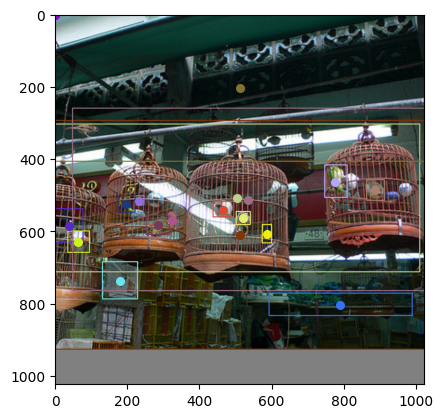

[[  77.  508.  177.  692.]
 [ 230.  350.  807.  863.]
 [ 807.  708.  911.  831.]
 [   0.    0.    0.    0.]
 [   0.  706.  163.  898.]
 [ 512.    0. 1024.  325.]
 [   0.  610. 1024. 1024.]
 [ 249.  798. 1024. 1024.]
 [   0.   97.  630.  903.]
 [ 563.  299. 1024.  817.]]


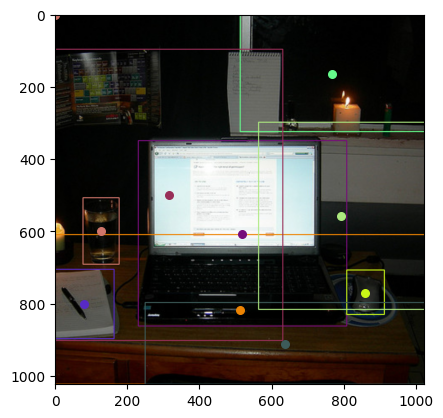

[[413.  41. 454. 196.]
 [303.  74. 310.  95.]
 [332.  86. 353. 151.]
 [169. 168. 189. 209.]
 [346.  83. 378. 175.]
 [141. 170. 171. 224.]
 [304.  71. 332. 171.]
 [371.  91. 424. 148.]
 [212.  86. 255. 135.]
 [  0.   1. 215. 255.]
 [289. 147. 379. 252.]
 [388.   0. 413.  40.]
 [294.  54. 344.  75.]
 [298.  51. 335.  66.]
 [325.  57. 387.  89.]
 [  0.  93. 424. 343.]
 [379.  20. 457.  69.]
 [206. 134. 457. 343.]
 [  0.   0. 457. 121.]]


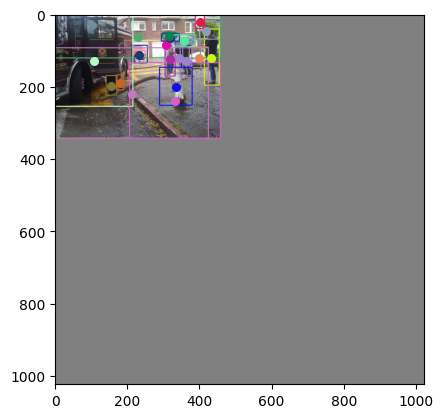

[[ 562.  262.  622.  313.]
 [ 648.  264.  675.  321.]
 [ 106.  483.  145.  555.]
 [ 511.  287.  532.  311.]
 [ 155.  485.  192.  557.]
 [ 472.  299.  487.  315.]
 [ 912.  549.  955.  614.]
 [ 341.  192.  914.  655.]
 [  81.  508.  210.  549.]
 [ 276.  524.  354.  604.]
 [ 890.  319. 1024.  604.]
 [   0.  508. 1024.  835.]
 [ 755.  254. 1024.  438.]
 [ 196.   61.  675.  344.]
 [   0.    0. 1024.  360.]
 [ 955.  428. 1024.  563.]
 [1018.  520. 1024.  534.]
 [   0.  158.  417.  567.]]


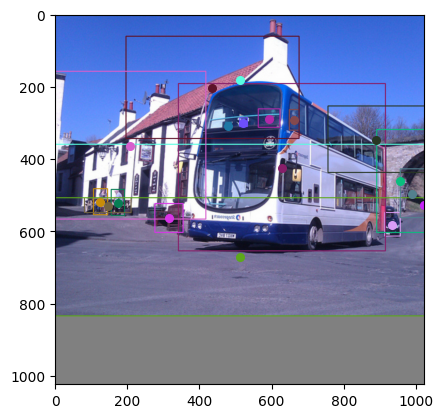

[[ 355.  130.  882.  880.]
 [ 297.  869.  929.  941.]
 [   0.    0. 1024. 1024.]]


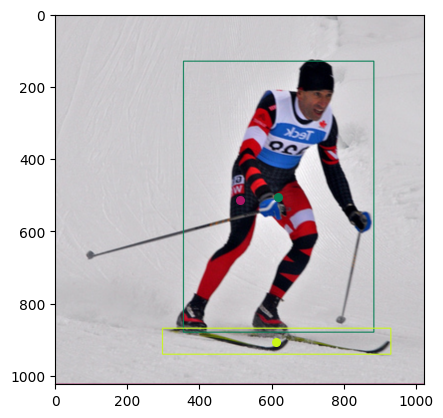

[[160. 118. 169. 135.]
 [208. 104. 219. 129.]
 [170. 104. 209. 135.]
 [218.  67. 303. 231.]
 [  0.  40.  61. 259.]
 [ 54. 109. 222. 187.]
 [ 49.  59. 186. 138.]
 [145.   0. 229.  13.]
 [  0.   0. 342. 262.]
 [136. 229. 350. 262.]
 [183.   0. 350. 249.]]


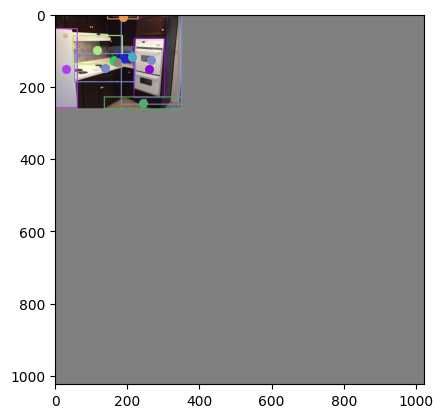

In [5]:
import cv2, random
from matplotlib import pyplot as plt
def random_color():
    rdn = random.randint(1, 1000)
    b = int(rdn * 997) % 255
    g = int(rdn * 4447) % 255
    r = int(rdn * 6563) % 255
    return b, g, r

with torch.no_grad():
    for idx, batches in enumerate(train_data_loader):
        if idx > 2:
            break
        for key, batch in batches.items():
            for idx, batch_per_image in enumerate(batch):
                obj_boxes = batch_per_image['instances'].gt_boxes.tensor
                target_img = batch_per_image["image"]
                img = target_img.permute(1, 2, 0).detach().cpu().numpy()
                obj_boxes = obj_boxes.cpu().numpy()

                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
                # targets_per_image = batch_per_image["instances"].to(opt.device)
                print(obj_boxes)
                for box in obj_boxes:
                    color = random_color()
                    box = box.astype(int)
                    x1, y1, x2, y2 = box
                    cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)

                    x = (x1 + x2) / 2
                    y = (y1 + y2) / 2

                    plt.scatter(x, y, 30, color=[i/255 for i in color])
                    # plt.text(
                    #     x + 5,
                    #     y + 5,
                    #     label,
                    #     fontsize=10,
                    #     bbox=dict(facecolor=[i/255 for i in color], alpha=0.5),
                    #     )
                
                plt.imshow(img)
                plt.show()